## Import statements

In [1]:
from Scripte.korpus import Korpus
from Scripte.settings import Settings

import json
import re
import string
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
from functools import reduce
from pathlib import Path
from datetime import datetime
from collections import Counter

from spacy.lang.de import German

In [2]:
nlp = spacy.load('de_core_news_lg')

## Functions

In [3]:
def _convert_text(text:str) -> str:
    replacements = [(r"http.+?\s", " "), (r"([a-z])([A-Z])", r"\1 \2"), (r"", ""), 
                    (r"", ""), (r"\*{2,}", ""), ("_+", ""), ]
    for old, new in reversed(replacements):
        text = text.replace(old, new)
    return _convert_entities(text)

def _convert_entities(text:str) -> str:
    doc = nlp(text)
    for entity in reversed(doc.ents):
        text = text[:entity.start_char] + entity.label_ + text[entity.end_char:]
    return text
    

def _convert_wordcount(number: str) -> int:
    return int(number.replace(".", ""))

def _convert_release(date:str):
    return datetime.strptime(date.strip(), "%d.%m.%Y")
 
def old_create_df(path, gender):
    data = reduce(lambda a, b: a.append(b, ignore_index= True), tqdm([create_part(x) for x in path]))
    data["gender"] = gender
    return data

def create_df(path, gender, genre):
    data = pd.concat([create_part(x) for x in tqdm(path)], ignore_index=True)
    data["gender"] = gender
    data["genre"] = genre
    return data

def contains_words(string : str, words) -> bool:
    return any(x in string for x in words)

def create_part(file) -> pd.DataFrame:
    start = json.load(open(file))
    x = pd.DataFrame.from_dict(start["chapters"], orient= "index", columns=["text", "wordcount"])
    x["text"] = x["text"].apply(_convert_text)
    x["wordcount"] = x["wordcount"].apply(_convert_wordcount)
    x["novel"] = re.sub(r"\W", " ", start["title"])
    x["release"] = _convert_release(start["release"])
    return x 
    

### Korpus aufbauen

In [4]:
#krimis
krimi_W = [x for x in Path("./jsondata/krimis/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
krimi_M = [x for x in Path("./jsondata/krimis/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
#horror
hor_W= [x for x in Path("./jsondata/horror/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
hor_M= [x for x in Path("./jsondata/horror/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
#abenteuer 
aben_W= [x for x in Path("./jsondata/abenteuer/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
aben_M= [x for x in Path("./jsondata/abenteuer/M").glob('**/*') if x.is_file() if x.suffix == ".json"]

#combined
json_M = krimi_M + hor_M + aben_M
json_W = krimi_W + hor_W + aben_W

### Diese Schritte brauchen eine Weile. Wenn ihr sie einmal durch habt, könnt ihr unten CSV save/ load verwenden 

In [5]:
data_krimi_M = create_df(krimi_M,"M", "krimi")
data_krimi_W = create_df(krimi_W,"W","krimi")

In [6]:
data_hor_M = create_df(hor_M, "M", "horror")
data_hor_W = create_df(hor_W,"W","horror")

In [7]:
data_aben_M = create_df(aben_M, "M", "abenteuer")
data_aben_W = create_df(aben_W,"W","abenteuer")

In [8]:
data_krimi_full = pd.concat([data_krimi_M, data_krimi_W],ignore_index=True)
data_aben_full = pd.concat([data_aben_M, data_aben_W],ignore_index=True)
data_hor_full = pd.concat([data_hor_M, data_hor_W],ignore_index=True)

## Summen der Wörter

## load and save from csv


In [9]:
data_krimi_full.to_csv("csv_data_krimi_full.csv", sep ="|")
data_aben_full.to_csv("csv_data_aben_full.csv", sep="|")
data_hor_full.to_csv("csv_data_hor_full.csv",sep="|")

In [10]:
data_krimi_full= pd.read_csv("csv_data_krimi_full.csv", sep ="|")
data_aben_full= pd.read_csv("csv_data_aben_full.csv", sep="|")
data_hor_full = pd.read_csv("csv_data_hor_full.csv",sep="|")

## build from csv files all permutations

In [11]:
data_krimi_M = data_krimi_full.loc[data_krimi_full["gender"] == "M"]
data_krimi_W = data_krimi_full.loc[data_krimi_full["gender"] == "W"]
data_aben_M = data_aben_full.loc[data_aben_full["gender"] == "M"]
data_aben_W = data_aben_full.loc[data_aben_full["gender"] == "W"]
data_hor_M = data_hor_full.loc[data_hor_full["gender"] == "M"]
data_hor_W = data_hor_full.loc[data_hor_full["gender"] == "W"]

# full gender views

data_all_M = pd.concat([data_krimi_M, data_aben_M, data_hor_M], ignore_index=True)
data_all_W = pd.concat([data_krimi_W, data_hor_W, data_aben_W], ignore_index=True)

data_all = pd.concat([data_krimi_full, data_aben_full, data_hor_full], ignore_index=True)


# Analyse und Berechnung

## Vorbereitung

In [12]:
joined_text_krimi_M = data_krimi_M.groupby('novel')['text'].apply(' '.join)
joined_text_krimi_W = data_krimi_W.groupby('novel')['text'].apply(' '.join)
joined_text_krimi_full = pd.concat([joined_text_krimi_M,joined_text_krimi_W])

In [13]:
joined_text_aben_W = data_aben_W.groupby('novel')['text'].apply(' '.join)
joined_text_aben_M = data_aben_M.groupby('novel')['text'].apply(' '.join)
joined_text_aben_full = pd.concat([joined_text_aben_M, joined_text_aben_W])

joined_text_hor_W = data_hor_W.groupby('novel')['text'].apply(' '.join)
joined_text_hor_M = data_hor_M.groupby('novel')['text'].apply(' '.join)
joined_text_hor_full = data_hor_full.groupby('novel')["text"].apply(' '.join)

joined_text_M_full = pd.concat([joined_text_krimi_M,  joined_text_aben_M]) #joined_text_hor_M,
joined_text_W_full = pd.concat([joined_text_krimi_W,  joined_text_aben_W])#joined_text_hor_W,

In [14]:
joined_text_all = data_all.groupby('novel')['text'].apply(' '.join)


## Dieser Schritt braucht etwas!

In [15]:
#wortlist für negative Emotionen 
#bekommen die Anzahl und der Anteil - die Wörter über negative Emotionen

nega_emo_list = 'abgeschlagen aggressiv alarmiert angeekelt angeschlagen angespannt angewidert ängstlich apathisch ärgerlich aufgebracht aufgehetzt ausgelaugt ausgepumpt bange bedrückt beklommen belästigt beleidigt beschämt bestürzt betroffen beunruhigt bitter bösartig chaotisch depressiv deprimiert dreckig dumpf durcheinander eifersüchtig eingebildet eingeschnappt einsam eitel elend empört entnervt entrüstet enttäuscht erkaltet erloschen ermüdet ernüchtert erschlagen erschöpft erschreckt erschrocken erschüttert erstarrt feindselig frustriert fuchsteufelswild furchtsam gehemmt gehetzt geknickt geladen gelähmt gelangweilt genervt gereizt gespannt gestresst getrieben gierig gleichgültig grübelnd grüblerisch hasserfüllt hilflos hoffnungslos hysterisch irritiert jammernd kränklich kribbelig lasch launisch leblos lethargisch lustlos miserabel missmutig misstrauisch müde mürrisch mutlos neidisch nervös niedergeschlagen panisch perplex pessimistisch quengelig rachsüchtig reizbar reumütig ruhelos sauer schadenfroh scheu schlapp schlecht schockiert schutzlos selbstzufrieden sorgenvoll stolz streitlustig teilnahmslos traurig trübsinnig überheblich unbehaglich unentschlossen ungeduldig unglücklich unruhig unsicher unterdrückt unwohl unzufrieden verachtet verängstigt verärgert verbittert verfolgt verlassen verlegen verletzt vernachlässigt verschlossen verspannt verstimmt verstört verunsichert verwirrt verzweifelt widerwillig wütend zappelig zögerlich zornig arrogant abgespannt aggressiv alarmiert angeekelt angespannt ängstlich angstschlotternd angreifend ärgerlich argwöhnisch aufgebracht ausgelaugt beängstigt bedrängt bedrückt befangen befremdet beklommen bekümmert belastet beleidigt beschämt besorgt bestürzt betroffen betrübt beunruhigt bitter blockiert bösartig brummig daneben depressiv deprimiert distanziert dumpf durcheinander eifersüchtig einsam ekelerfüllt empfindlich empört energielos entmutigt entrüstet entsetzt enttäuscht ermüdet ernüchtert erregt erschlagen erschöpft erschrocken erzürnt feindselig feststeckend frustriert furchtsam feindlich gehässig gehemmt geladen gelangweilt gemein gequält gereizt gestört gewalttätig gleichgültig griesgrämig grantig hasserfüllt herabgewürdigt hilflos hitzköpfig hoffnungslos hundsmiserabel irritiert jämmerlich kalt kribbelig kraftlos launisch leer lüstern lustlos masochistisch mäkelnd missmutig misstrauisch mies müde mürrisch mutlos neidisch nervös niedergeschlagen niederträchtig nachtragend ohnmächtig panisch peinlich perplex pessimistisch ratlos ruhelos rasend rachsüchtig sauer sadistisch scheu schläfrig schlapp schmollend schockiert schuldig selbstkritisch selbstverachtend scheußlich schmerzerfüllt schwermütig schwunglos skeptisch sorgenvoll strapaziert streitlustig teilnahmslos träge traurig trübselig überdrüssig überfordert überlastet unangenehm unbehaglich unbeteiligt ungeduldig ungehalten ungemütlich unglücklich unklar unnahbar unruhig unschlüssig unsicher unwohl unzufrieden verängstigt verärgert verbittert verkrampft verlegen verletzbar verletzt verloren verrückt verschlafen verschlossen verschreckt verspannt verstimmt verstört verunsichert verwirrt verzagt verzweifelt vorwurfsvoll weinerlich widerwillig wütend wutentbrannt zappelig zerknirscht zermürbt zerrissen zittrig zögerlich zornig zurückgewiesen zynisch'

nega_emo_final = [token.lemma_ for token in nlp(nega_emo_list)]

def get_nega_emo_ratio(series)-> pd.DataFrame:
    results = []
    for novel, text in series.items():
        if len(text)> nlp.max_length:
            for x in _get_results(novel,text):
                results.append(x)
                print(f"LOG: finished {novel}")
        else:
            results.append([novel]+calc_data(text))
            print(f"LOG: finished {novel}")
    df = pd.DataFrame(results, columns=['novel', 'nega_emo_sum', 'nega_emo_type', 'Total Words', 'Percentage'])

    return df

def _get_results(novel:str, text:str):
    results = []
    chunks = [text[i:i+nlp.max_length] for i in range(0, len(text), nlp.max_length)]
    for i, chunk in enumerate(chunks):
        str_ = f"{novel}_{i}"
        results.append([str_]+ calc_data(chunk))
    return results

def calc_data(text): 
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ != "--"]
    count_part = Counter([lemma for lemma in lemmas if lemma in nega_emo_final])
    nega_emo_sum = sum(count_part.values())
    nega_emo_types = len(count_part)
    total_words = len(lemmas)
    percentage = (nega_emo_sum / total_words) * 100
                       
    return [nega_emo_sum, nega_emo_types, total_words, percentage]


# Dies hier wird weiter bearbeitet!

In [16]:
nlp.max_length = 600000

data_comp1_krimi = get_nega_emo_ratio(joined_text_krimi_W)
data_comp1_krimi["field"] = "krimi_W"
data_comp2_krimi = get_nega_emo_ratio(joined_text_krimi_M)
data_comp2_krimi["field"] = "krimi_M"


LOG: finished Albtraum
LOG: finished Alina
LOG: finished Aller Anfang ist schwer
LOG: finished Angel  Arbeitstitel 
LOG: finished Anonym
LOG: finished Auf den Spuren der Vergangenheit
LOG: finished Authorities Task Force
LOG: finished Being Jack
LOG: finished Broken Mirrors   
LOG: finished Bruderliebe
LOG: finished CRY
LOG: finished Cube
LOG: finished Das Attentat
LOG: finished Das Böse hat ein Herz
LOG: finished Das mörderische Krimidinner
LOG: finished Death Teacher
LOG: finished Der Anfang der Katastrophen oder London calling
LOG: finished Der Diamantenprinz
LOG: finished Der Fall Lukis
LOG: finished Der Herzensbrecher
LOG: finished Der Mountie   Das Geheimnis der toten Elche
LOG: finished Der Zweck heiligt die Mittel
LOG: finished Der erste Fall
LOG: finished Die Entführung
LOG: finished Die Fassade
LOG: finished Die Nacht im Mai
LOG: finished Die Stunde der Angst
LOG: finished Die weiße Witwe
LOG: finished Eiskalt
LOG: finished Emma
LOG: finished Falsche Sterne über Tokyo
LOG: fi

In [17]:
data_final_krimi = pd.concat([data_comp1_krimi, data_comp2_krimi])
data_final_krimi

,novel,nega_emo_sum,nega_emo_type,Total Words,Percentage,field
0,Albtraum,52,23,19159,0.271413,krimi_W
1,Alina,81,41,12850,0.630350,krimi_W
2,Aller Anfang ist schwer,82,46,14258,0.575116,krimi_W
3,Angel Arbeitstitel,61,38,11685,0.522037,krimi_W
4,Anonym,22,17,11066,0.198807,krimi_W
...,...,...,...,...,...,...
27,Tote Helden,145,50,35750,0.405594,krimi_M
28,Tödliche Begegnung,111,41,31566,0.351644,krimi_M
29,Unter Verdacht,81,36,21994,0.368282,krimi_M
30,Verraten,57,25,15481,0.368193,krimi_M


In [18]:
nlp.max_length = 600000

data_comp1_aben = get_nega_emo_ratio(joined_text_aben_W)
data_comp1_aben["field"] = "aben_W"
data_comp2_aben = get_nega_emo_ratio(joined_text_aben_M)
data_comp2_aben["field"] = "aben_M"

LOG: finished A Way Out
LOG: finished Afrika im Herzen
LOG: finished Afrika im Herzen
LOG: finished Afterlife
LOG: finished Ai e no pasu
LOG: finished Alvaro   Der Preis der Freiheit
LOG: finished Auf der Suche
LOG: finished Außer Kontrolle
LOG: finished Außer Kontrolle
LOG: finished Bedrohliche Zeiten
LOG: finished Blue Jay Storys   Wohin der Wind dich trägt  Mitmachgeschichte 
LOG: finished Blue Jay Storys   Wohin der Wind dich trägt  Mitmachgeschichte 
LOG: finished Chroniken der Stämme Spotlight  Licht und Schatten  Teil 1 
LOG: finished Dark Revolution
LOG: finished Das Abenteuer beginnt 
LOG: finished Das Auge des Horus
LOG: finished Das geheimnisvolle Kriegervolk
LOG: finished Der Jäger und das Geheimnis von Korinth
LOG: finished Der Stein des blauen Mondes
LOG: finished Der Waldläufer Nousagi
LOG: finished Die Chroniken der Verborgenen Lande   Martin von Wengland   Das Turnier
LOG: finished Die Chroniken der Verborgenen Lande   Martin von Wengland   Einer spielt falsch
LOG: fin

In [19]:
data_final_aben = pd.concat([data_comp1_aben, data_comp2_aben])
data_final_aben

,novel,nega_emo_sum,nega_emo_type,Total Words,Percentage,field
0,A Way Out,44,31,12914,0.340716,aben_W
1,Afrika im Herzen_0,596,122,97613,0.610574,aben_W
2,Afrika im Herzen_1,421,97,66866,0.629617,aben_W
3,Afterlife,68,32,13869,0.490302,aben_W
4,Ai e no pasu,54,25,13260,0.407240,aben_W
...,...,...,...,...,...,...
44,Tokyo Devils Tokyo Sharks_1,371,82,97000,0.382474,aben_M
45,Tokyo Devils Tokyo Sharks_2,394,86,97880,0.402534,aben_M
46,Tokyo Devils Tokyo Sharks_3,24,15,4109,0.584084,aben_M
47,Ulrik 2_0,404,92,97277,0.415309,aben_M


In [20]:
data_comp1_hor = get_nega_emo_ratio(joined_text_hor_W)
data_comp1_hor["field"] = "hor_W"
data_comp2_hor = get_nega_emo_ratio(joined_text_hor_M)
data_comp2_hor["field"] = "hor_M"



LOG: finished 43 Stunden
LOG: finished 7 Tage Wahnsinn
LOG: finished Aloha From Hell
LOG: finished Am Ende des Tages
LOG: finished Amusement Park
LOG: finished Another Fear
LOG: finished Archiviert ZOE   DAS LEBEN DES SCHATTEN  BAND I  
LOG: finished Archiviert ZOE   DAS LEBEN DES SCHATTEN  BAND I  
LOG: finished Archiviert ZOE   DAS LEBEN DES SCHATTEN  BAND I  
LOG: finished Archiviert ZOE   DAS VERMÄCHTNIS DER ERBEN  BAND II  
LOG: finished Archiviert ZOE   DAS VERMÄCHTNIS DER ERBEN  BAND II  
LOG: finished Archiviert ZOE   DAS VERMÄCHTNIS DER ERBEN  BAND II  
LOG: finished Archiviert ZOE   DAS VERMÄCHTNIS DER ERBEN  BAND II  
LOG: finished Archiviert ZOE   Das Leben der Mörderin   Band I 
LOG: finished Archiviert ZOE   Das Leben der Mörderin   Band I 
LOG: finished Archiviert ZOE   Das Leben der Mörderin   Band II 
LOG: finished Archiviert ZOE   Das Leben der Mörderin   Band II 
LOG: finished Archiviert ZOE   Das Leben der Mörderin   Band II 
LOG: finished Archiviert ZOE   Einhunder

In [21]:
data_final_hor = pd.concat([data_comp1_hor, data_comp2_hor])
data_final_hor

,novel,nega_emo_sum,nega_emo_type,Total Words,Percentage,field
0,43 Stunden,101,47,13566,0.744508,hor_W
1,7 Tage Wahnsinn,79,31,12090,0.653433,hor_W
2,Aloha From Hell,112,51,19602,0.571370,hor_W
3,Am Ende des Tages,93,38,13800,0.673913,hor_W
4,Amusement Park,77,41,18122,0.424898,hor_W
...,...,...,...,...,...,...
36,Its hard to survive___Eine Zombie Apokalypse M...,154,65,33041,0.466088,hor_M
37,Justitia Games,91,49,16642,0.546809,hor_M
38,Klassentreffen,47,25,13121,0.358204,hor_M
39,Kuss der Nacht,14,12,2786,0.502513,hor_M


In [25]:
data_comp1_full = get_nega_emo_ratio(joined_text_W_full)
data_comp1_full["field"] = "W"
data_comp2_full = get_nega_emo_ratio(joined_text_M_full)
data_comp2_full["field"] = "M"

LOG: finished Albtraum
LOG: finished Alina
LOG: finished Aller Anfang ist schwer
LOG: finished Angel  Arbeitstitel 
LOG: finished Anonym
LOG: finished Auf den Spuren der Vergangenheit
LOG: finished Authorities Task Force
LOG: finished Being Jack
LOG: finished Broken Mirrors   
LOG: finished Bruderliebe
LOG: finished CRY
LOG: finished Cube
LOG: finished Das Attentat
LOG: finished Das Böse hat ein Herz
LOG: finished Das mörderische Krimidinner
LOG: finished Death Teacher
LOG: finished Der Anfang der Katastrophen oder London calling
LOG: finished Der Diamantenprinz
LOG: finished Der Fall Lukis
LOG: finished Der Herzensbrecher
LOG: finished Der Mountie   Das Geheimnis der toten Elche
LOG: finished Der Zweck heiligt die Mittel
LOG: finished Der erste Fall
LOG: finished Die Entführung
LOG: finished Die Fassade
LOG: finished Die Nacht im Mai
LOG: finished Die Stunde der Angst
LOG: finished Die weiße Witwe
LOG: finished Eiskalt
LOG: finished Emma
LOG: finished Falsche Sterne über Tokyo
LOG: fi

In [26]:
data_final_full = pd.concat([data_comp1_full, data_comp2_full])
data_final_full

,novel,nega_emo_sum,nega_emo_type,Total Words,Percentage,field
0,Albtraum,52,23,19159,0.271413,W
1,Alina,81,41,12850,0.630350,W
2,Aller Anfang ist schwer,82,46,14258,0.575116,W
3,Angel Arbeitstitel,61,38,11685,0.522037,W
4,Anonym,22,17,11066,0.198807,W
...,...,...,...,...,...,...
76,Tokyo Devils Tokyo Sharks_1,371,82,97000,0.382474,M
77,Tokyo Devils Tokyo Sharks_2,394,86,97880,0.402534,M
78,Tokyo Devils Tokyo Sharks_3,24,15,4109,0.584084,M
79,Ulrik 2_0,404,92,97277,0.415309,M


## Plotting

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# to make sure to not lose data, plots can be saved, make sure you change filename if you use this option
SAVE_FILES = True

subdirectory = Path('plots')
subdirectory.mkdir(parents=True, exist_ok=True)
#FILENAME- CHANGE THIS
plot_name = 'bar_hor_full_brut_type.png'
file_path = subdirectory / plot_name

# Viewing the Data

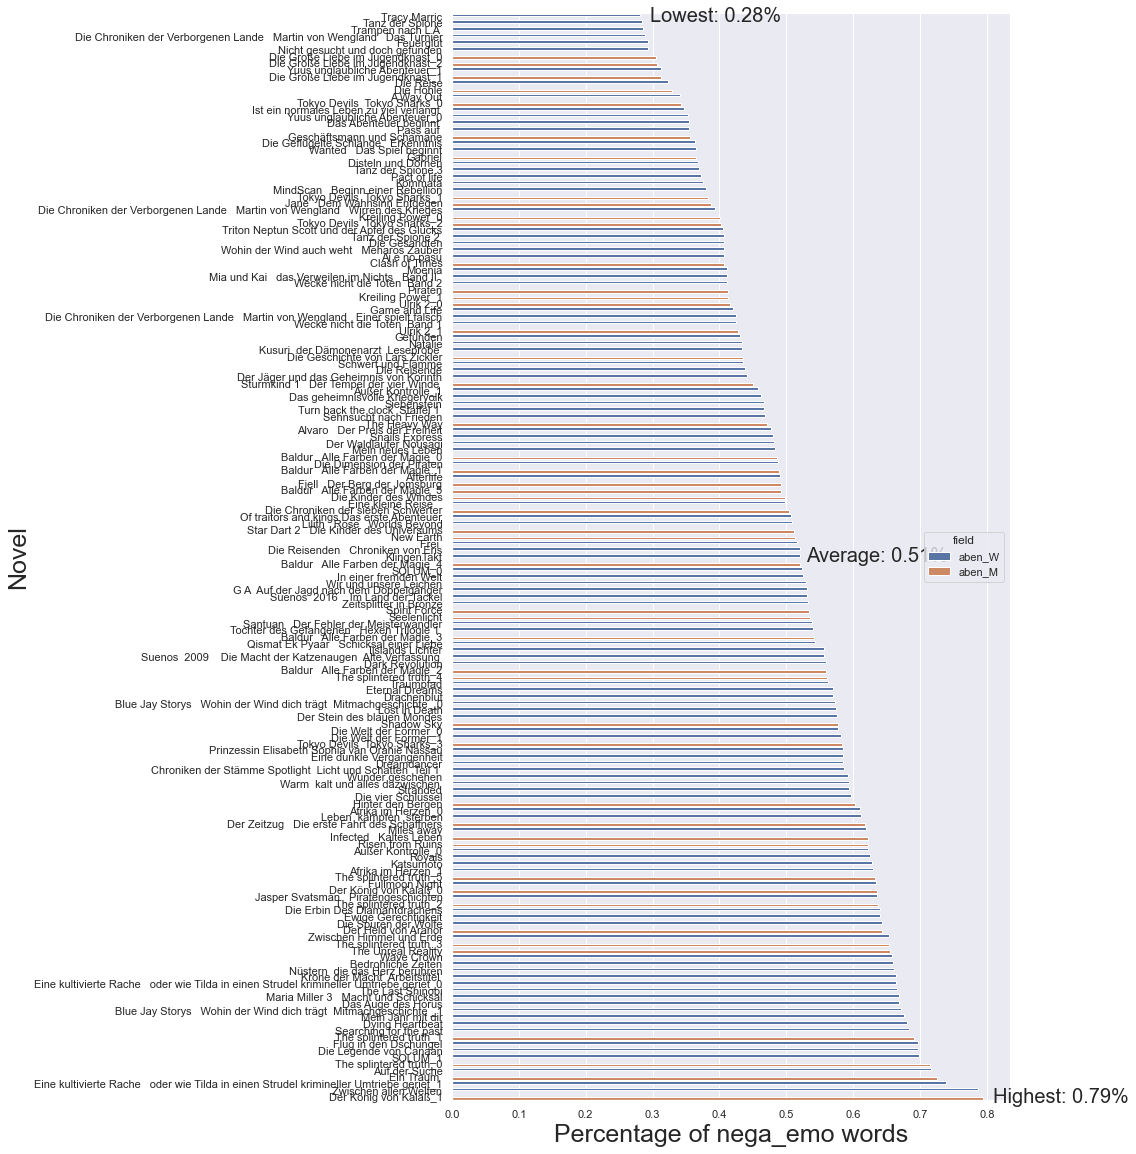

In [48]:
#Die Tabelle von aben
data_final_aben = pd.concat([data_comp1_aben, data_comp2_aben])
df_aben =  data_final_aben.sort_values('Percentage', ascending=True)

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df_aben)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_aben['Percentage'].max()
lowest_percentage = df_aben['Percentage'].min()
average_percentage = df_aben['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_aben)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_aben)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

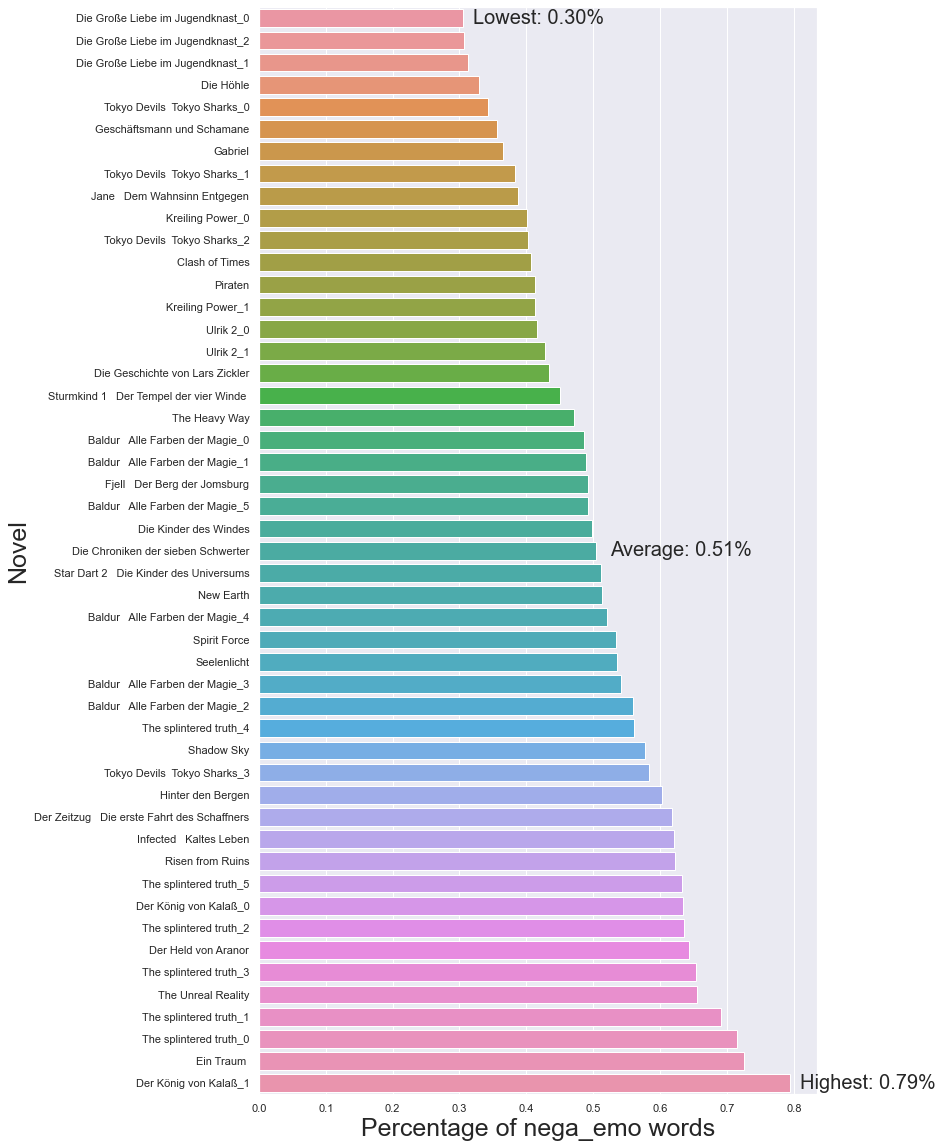

In [49]:
#Die Tabelle von aben_M
data_final_aben_M = pd.concat([data_comp2_aben])
df_aben_M =  data_final_aben_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_aben_M)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_aben_M['Percentage'].max()
lowest_percentage = df_aben_M['Percentage'].min()
average_percentage = df_aben_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_aben_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_aben_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

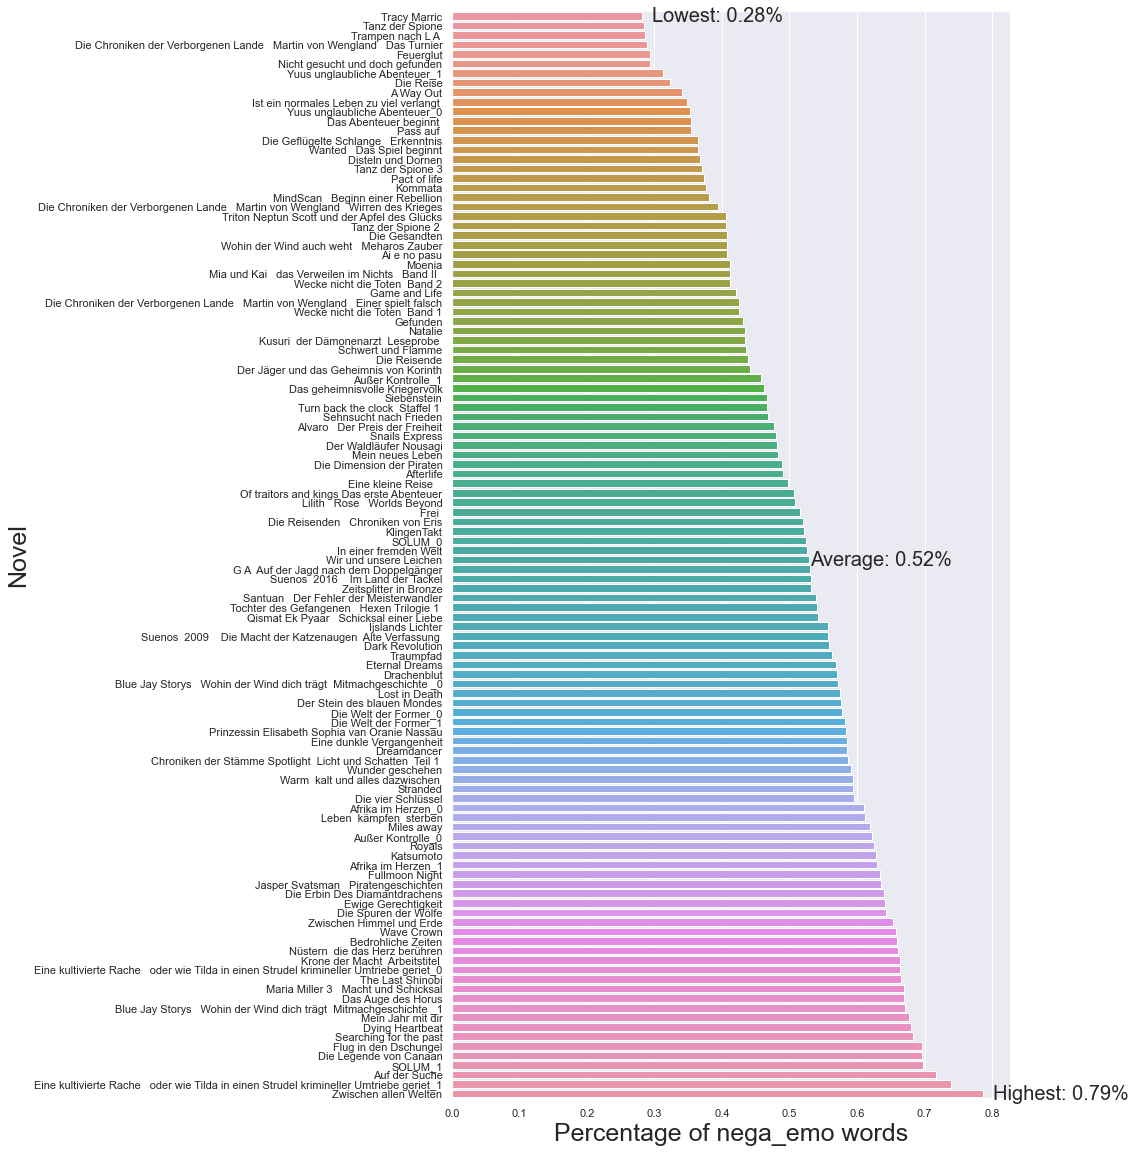

In [50]:
#Die Tabelle von aben_W
data_final_aben_W = pd.concat([data_comp1_aben])
df_aben_W =  data_final_aben_W.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_aben_W)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_aben_W['Percentage'].max()
lowest_percentage = df_aben_W['Percentage'].min()
average_percentage = df_aben_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_aben_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_aben_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

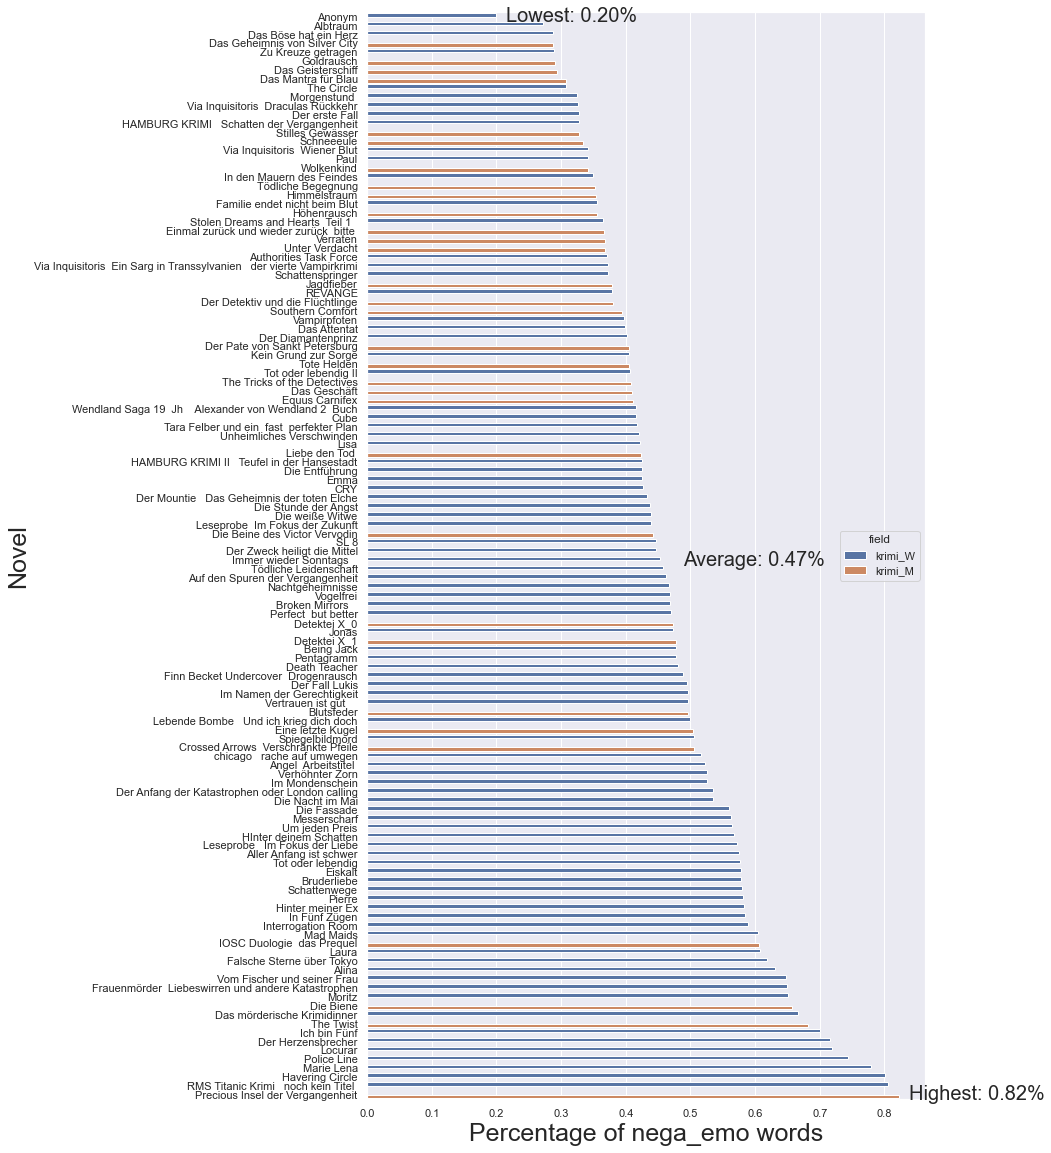

In [51]:
#Die Tabelle von Krimi
data_final_krimi = pd.concat([data_comp1_krimi, data_comp2_krimi])
df_krimi =  data_final_krimi.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df_krimi)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_krimi['Percentage'].max()
lowest_percentage = df_krimi['Percentage'].min()
average_percentage = df_krimi['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_krimi)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_krimi)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

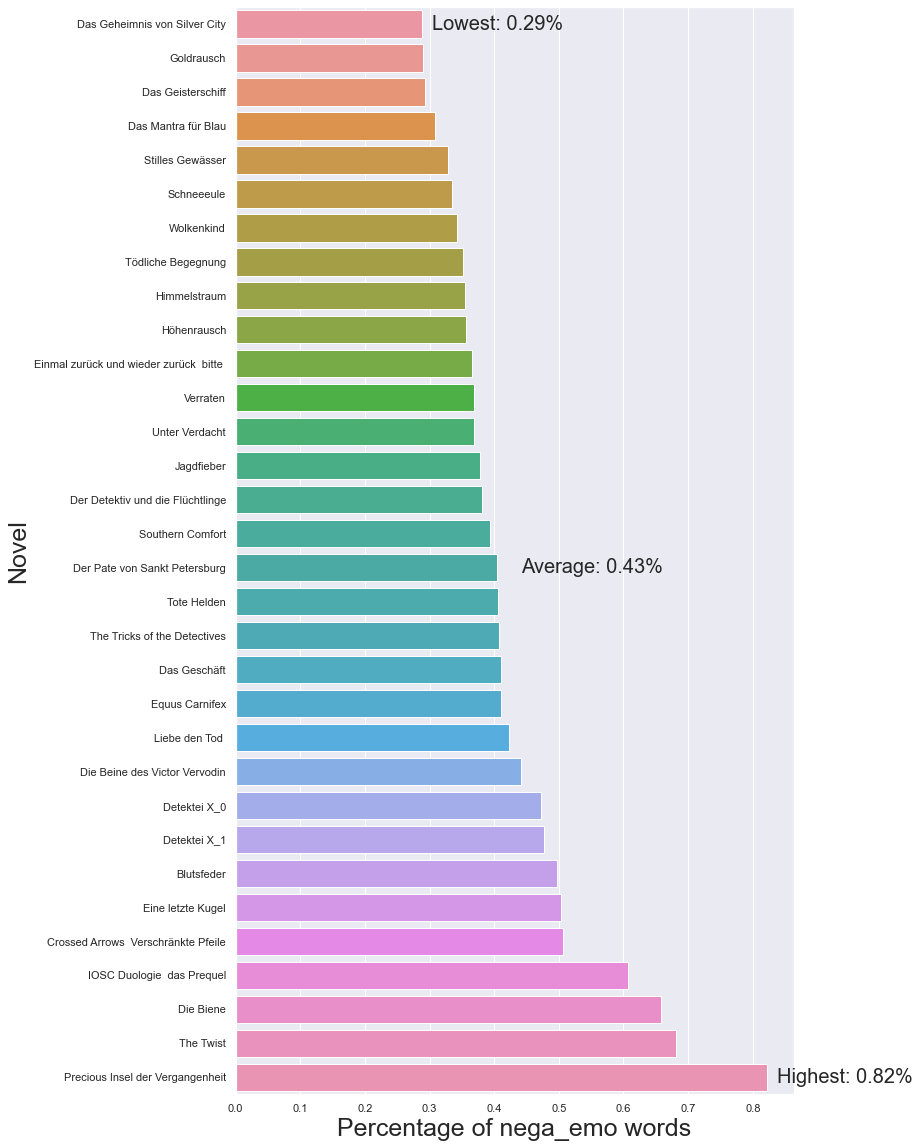

In [52]:
#Die Tabelle von Krimi_M
data_final_krimi_M = pd.concat([data_comp2_krimi])
df_krimi_M =  data_final_krimi_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_krimi_M)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_krimi_M['Percentage'].max()
lowest_percentage = df_krimi_M['Percentage'].min()
average_percentage = df_krimi_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_krimi_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_krimi_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

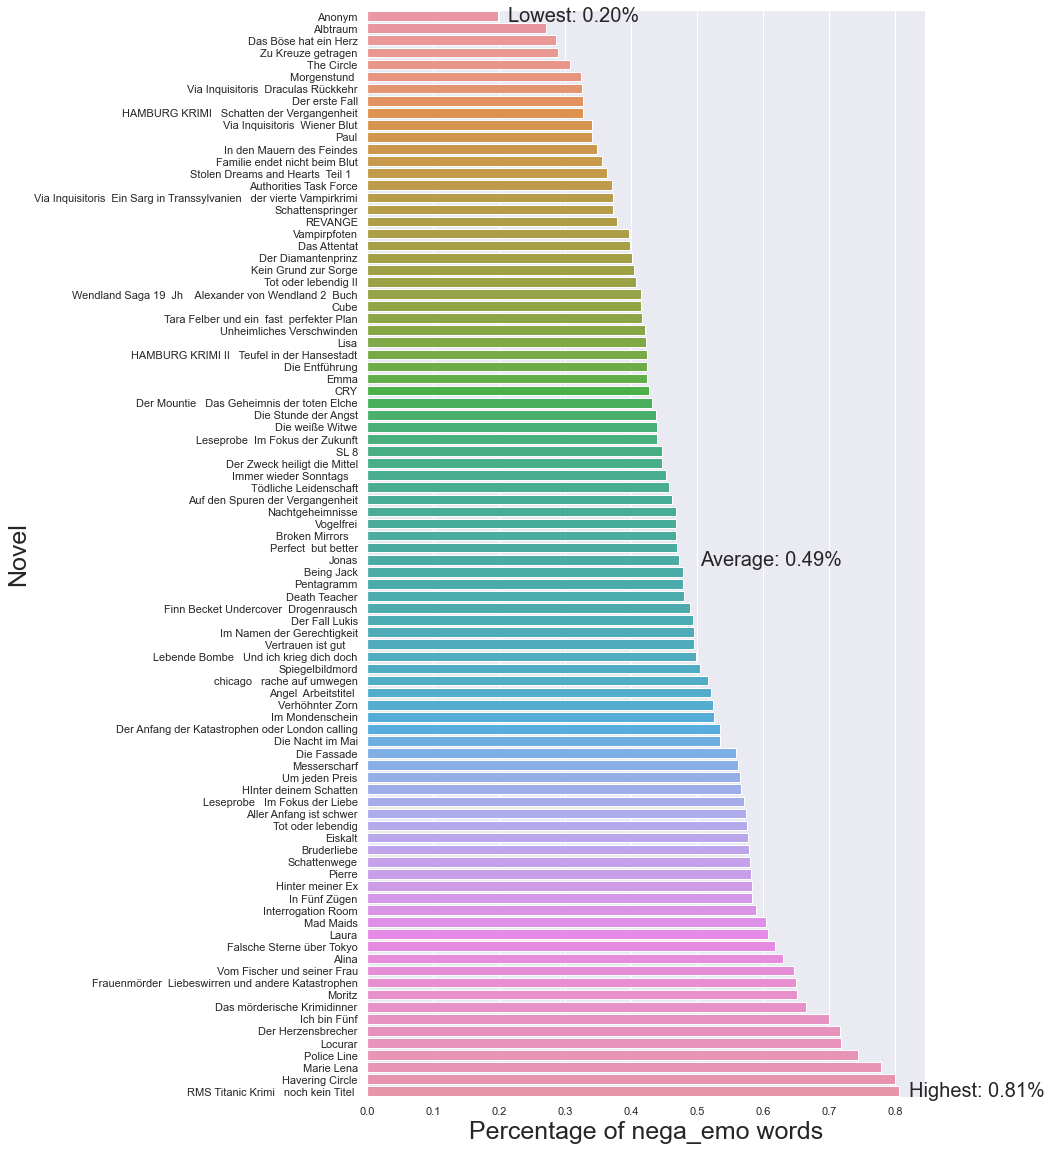

In [53]:
#Die Tabelle von Krimi_W
data_final_krimi_W = pd.concat([data_comp1_krimi])
df_krimi_W =  data_final_krimi_W.sort_values('Percentage', ascending=True)

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_krimi_W)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_krimi_W['Percentage'].max()
lowest_percentage = df_krimi_W['Percentage'].min()
average_percentage = df_krimi_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_krimi_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_krimi_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

In [54]:
#Die Tabelle von hor
df_hor =  data_final_hor.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

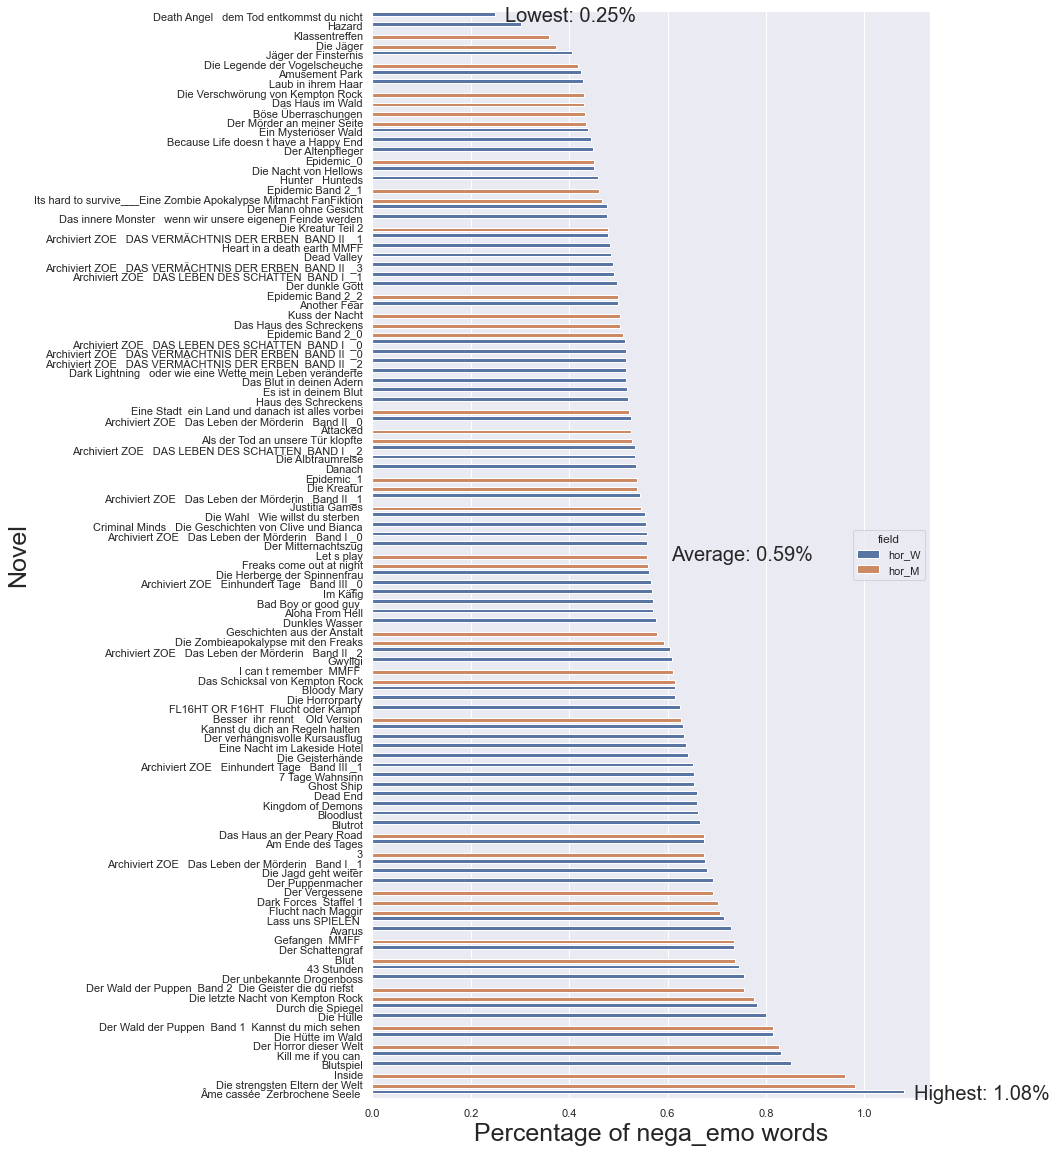

In [55]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df_hor)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_hor['Percentage'].max()
lowest_percentage = df_hor['Percentage'].min()
average_percentage = df_hor['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_hor)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_hor)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

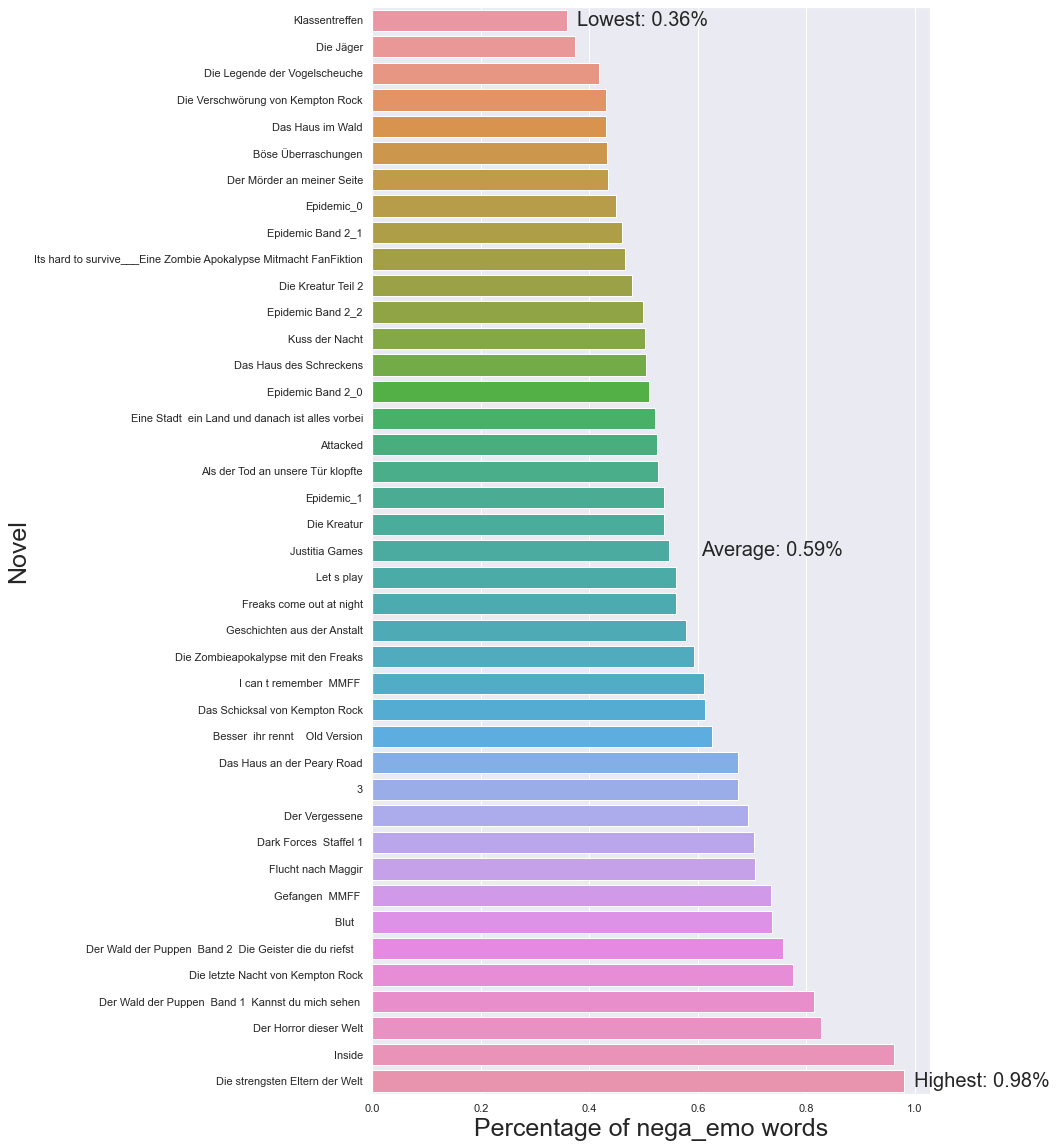

In [56]:
#Die Tabelle von hor_M
data_final_hor_M =  pd.concat([data_comp2_hor])
df_hor_M =  data_final_hor_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_hor_M)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_hor_M['Percentage'].max()
lowest_percentage = df_hor_M['Percentage'].min()
average_percentage = df_hor_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_hor_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_hor_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

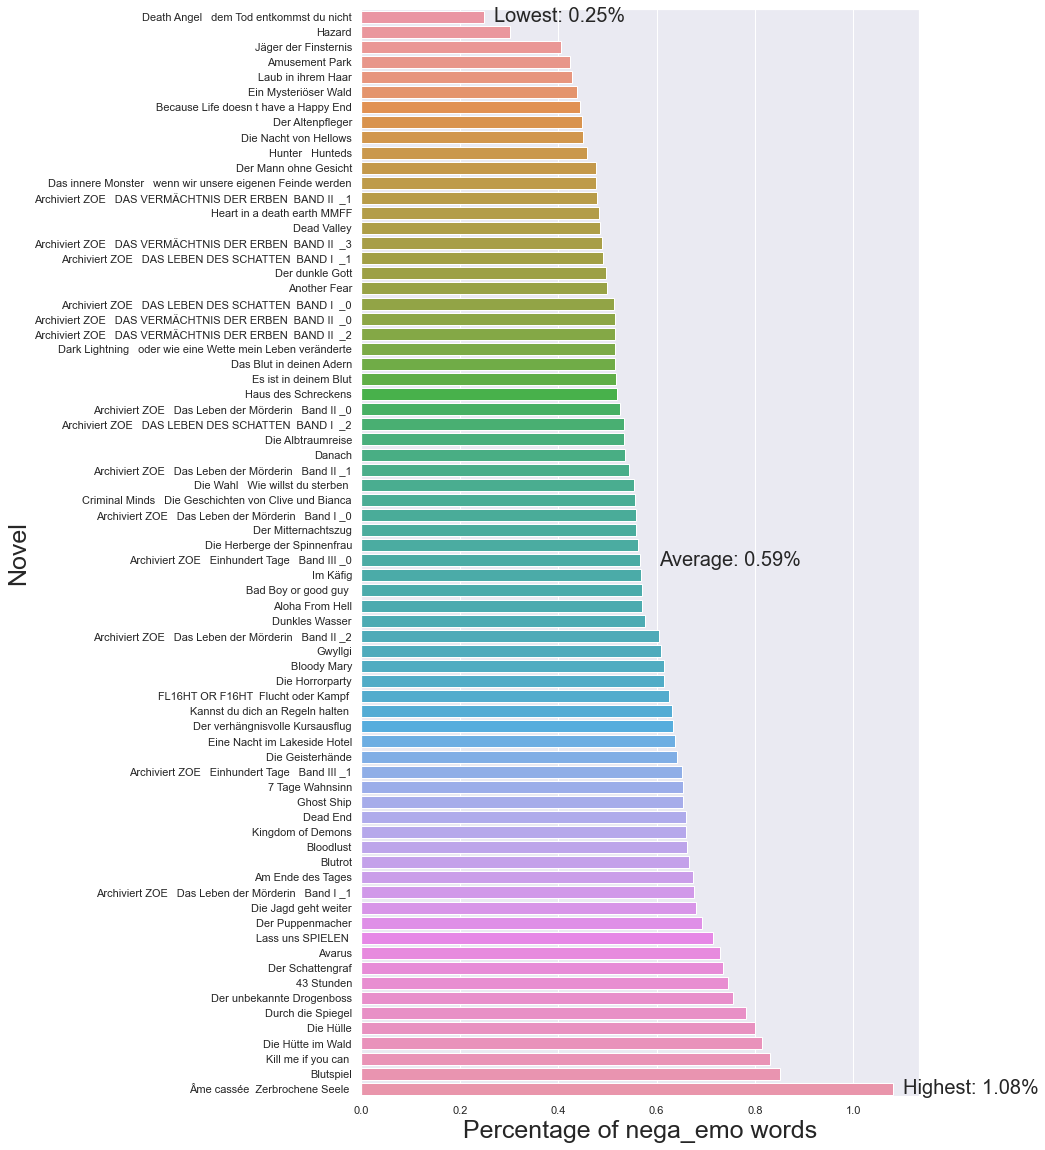

In [57]:
#Die Tabelle von hor_W
data_final_hor_W =  pd.concat([data_comp1_hor])
df_hor_W =  data_final_hor_W.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_hor_W)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_hor_W['Percentage'].max()
lowest_percentage = df_hor_W['Percentage'].min()
average_percentage = df_hor_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_hor_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_hor_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

In [39]:
#Die Tabelle von full
data_final_full = pd.concat([data_comp1_full, data_comp2_full])
df_full =  data_final_full.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

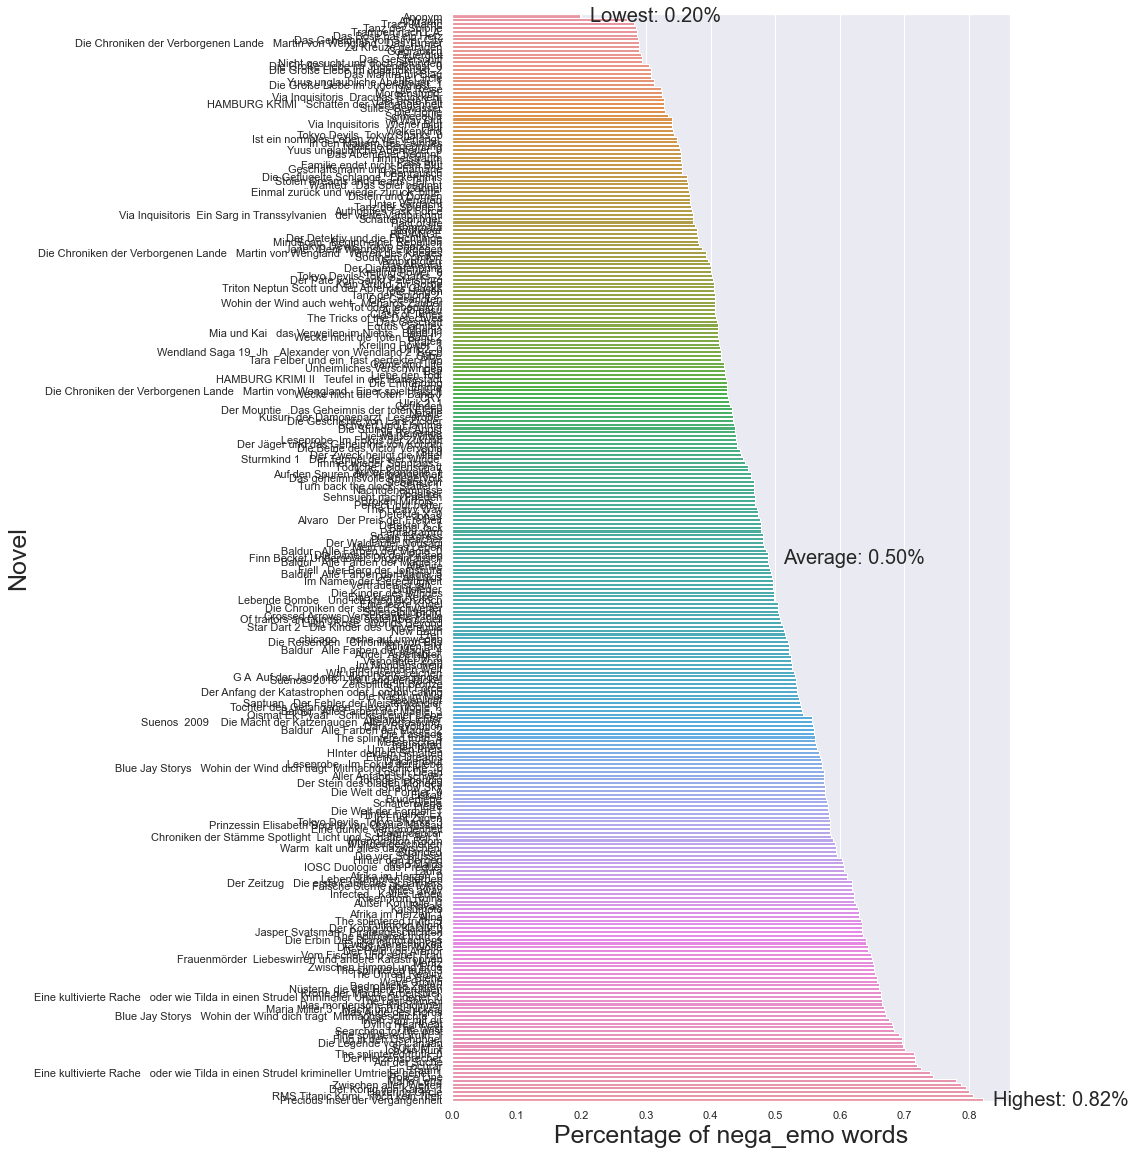

In [58]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_full)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_full['Percentage'].max()
lowest_percentage = df_full['Percentage'].min()
average_percentage = df_full['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_full)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_full)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

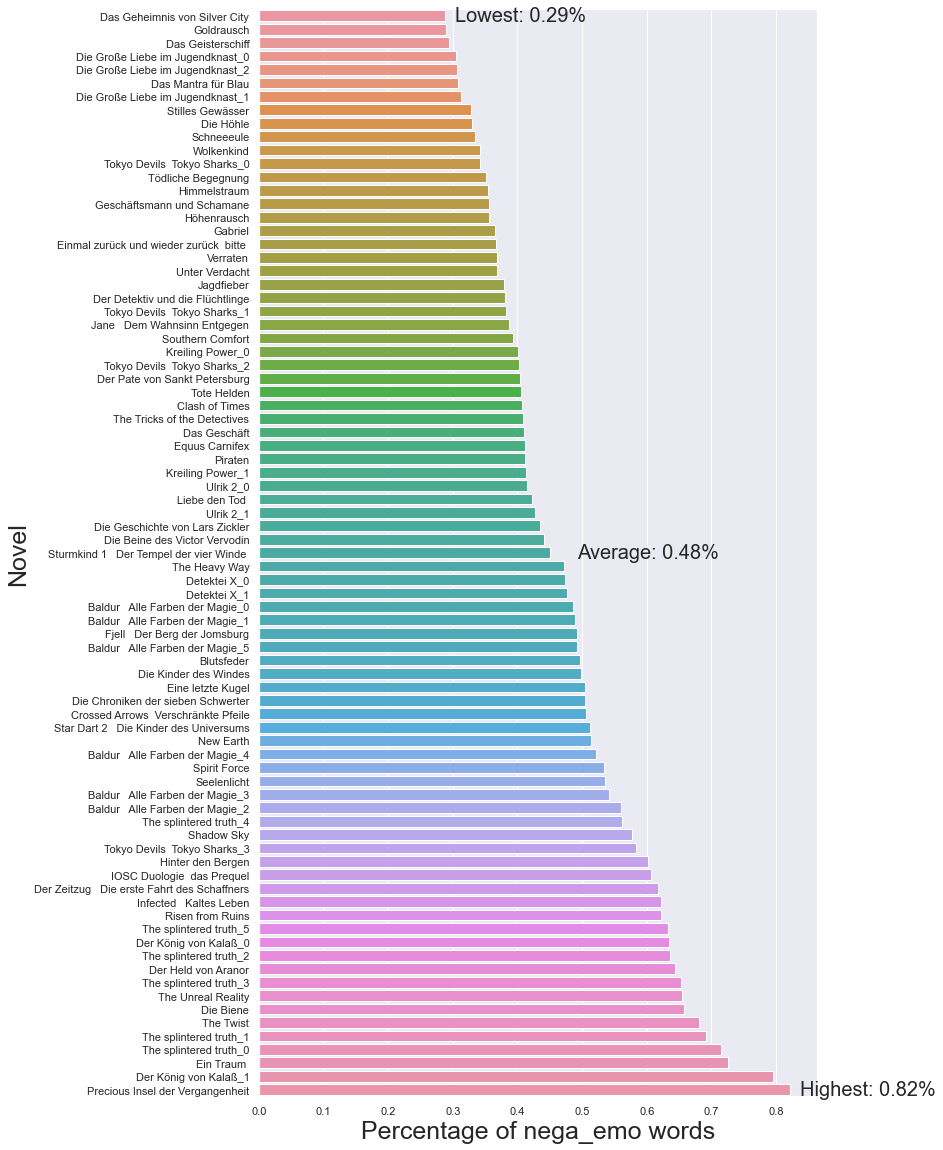

In [59]:
#Die Tabelle von full_M
data_final_full_M = pd.concat([data_comp2_full])
df_full_M =  data_final_full_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_full_M)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_full_M['Percentage'].max()
lowest_percentage = df_full_M['Percentage'].min()
average_percentage = df_full_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_full_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_full_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

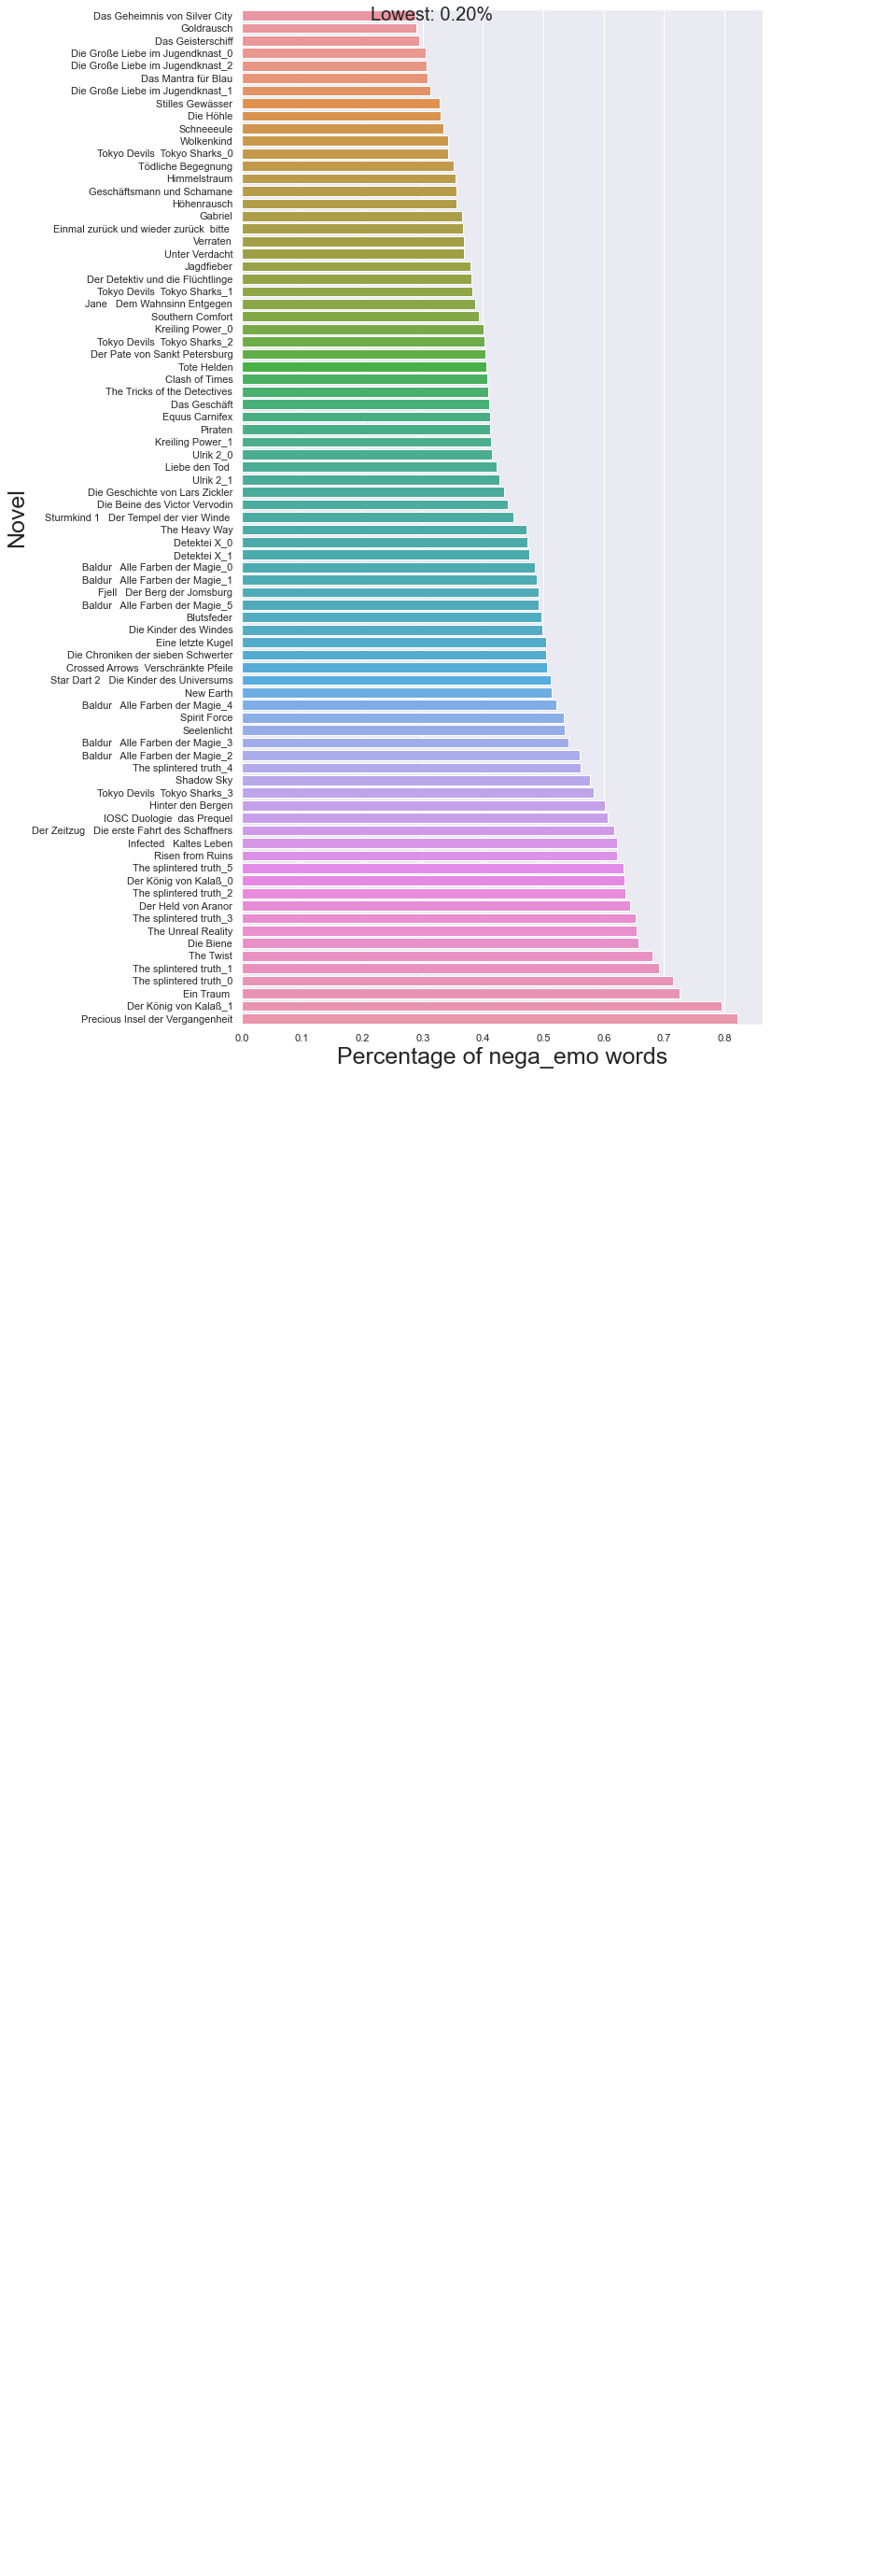

In [60]:
#Die Tabelle von full_W
data_final_full_W = pd.concat([data_comp1_full])
df_full_W =  data_final_full_W.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_full_M)

plt.xlabel('Percentage of nega_emo words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_full_W['Percentage'].max()
lowest_percentage = df_full_W['Percentage'].min()
average_percentage = df_full_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_full_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_full_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

# Comparison plots

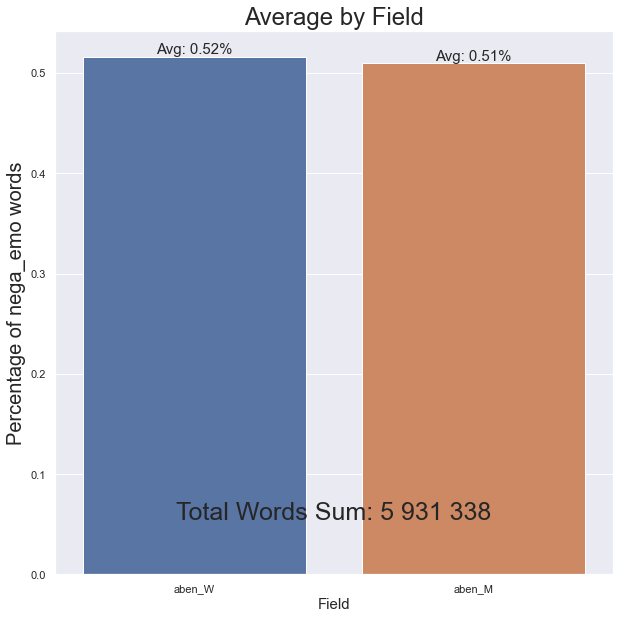

In [61]:
#Vergleichtabelle für aben
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_aben, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df_aben.groupby('field')['Percentage'].mean()
total_words_sum = df_aben['Total Words'].sum()

for i, field in enumerate(df_aben['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of nega_emo words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

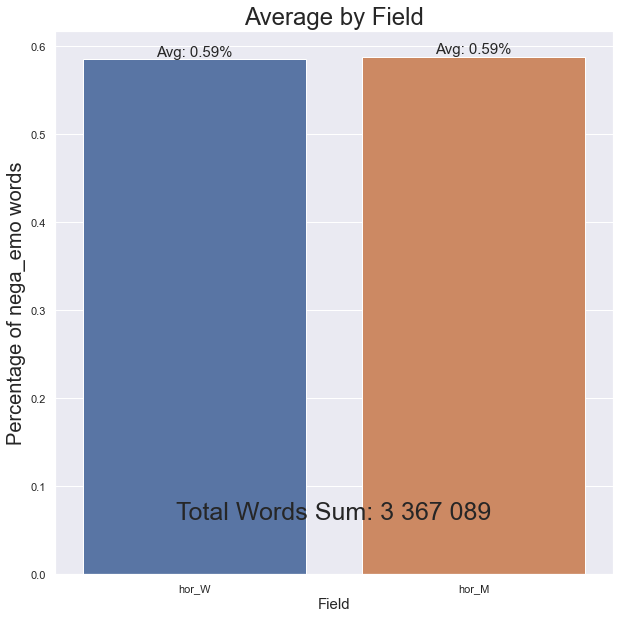

In [63]:
#Vergleichtabelle für hor
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_hor, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df_hor.groupby('field')['Percentage'].mean()
total_words_sum = df_hor['Total Words'].sum()

for i, field in enumerate(df_hor['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of nega_emo words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

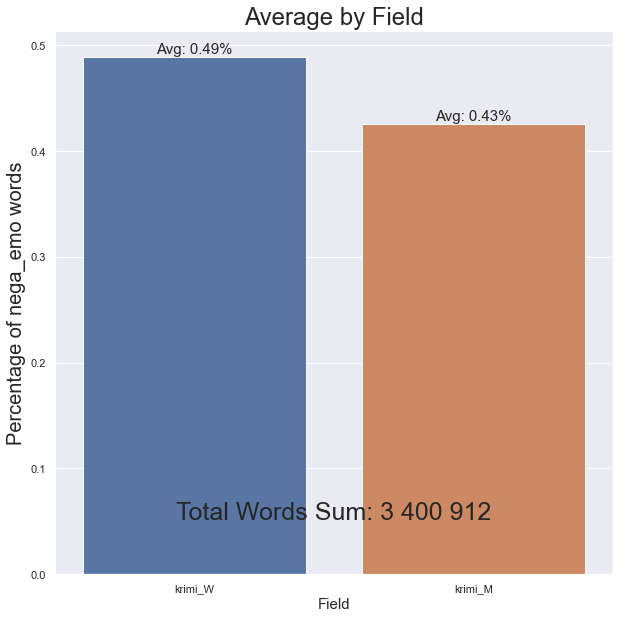

In [64]:
#Vergleichtabelle für krimi

sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_krimi, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df_krimi.groupby('field')['Percentage'].mean()
total_words_sum = df_krimi['Total Words'].sum()

for i, field in enumerate(df_krimi['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of nega_emo words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

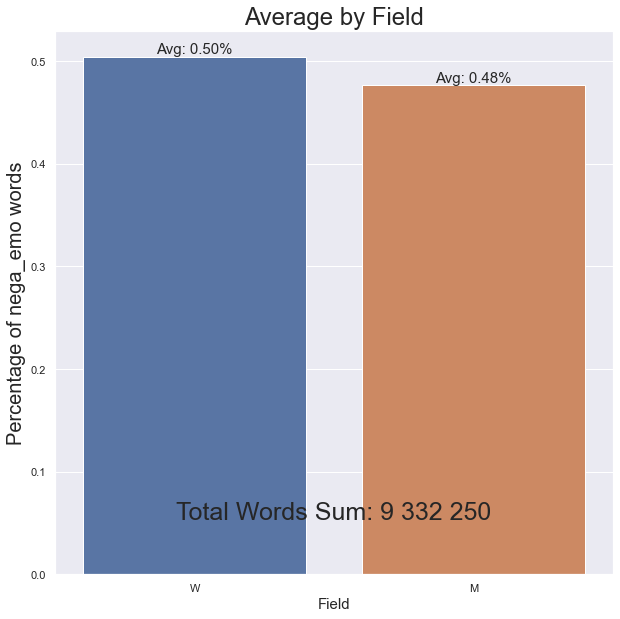

In [65]:
#Vergleichtabelle für full

data_final_full = pd.concat([data_comp1_full, data_comp2_full])
df_full =  data_final_full.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_full, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group

average_per_group = df_full.groupby('field')['Percentage'].mean()
total_words_sum = df_full['Total Words'].sum()

for i, field in enumerate(df_full['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of nega_emo words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

# Brut Types

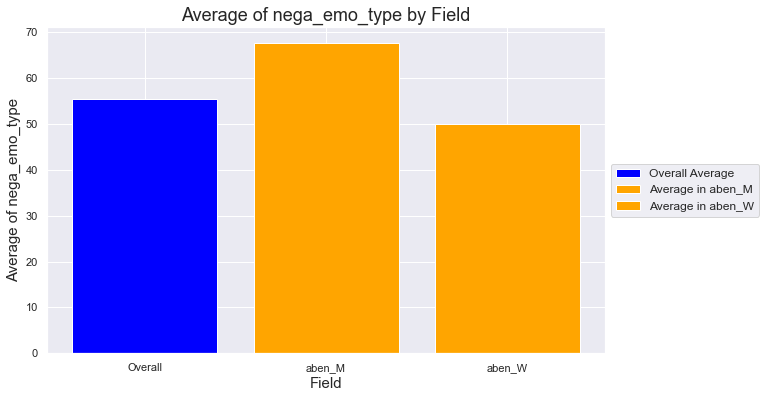

In [73]:
overall_avg_nega_emo_type = df_aben['nega_emo_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df_aben.groupby('field')['nega_emo_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_nega_emo_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of nega_emo_type', fontsize=15)
plt.title('Average of nega_emo_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')


plt.show()

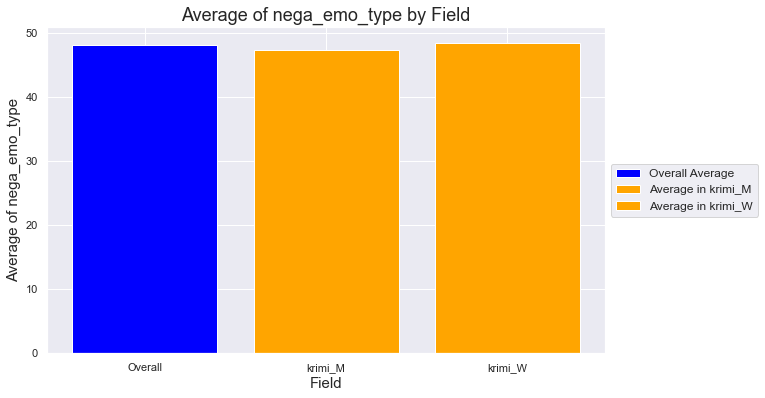

In [74]:
overall_avg_brut_type = df_krimi['nega_emo_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df_krimi.groupby('field')['nega_emo_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of nega_emo_type', fontsize=15)
plt.title('Average of nega_emo_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

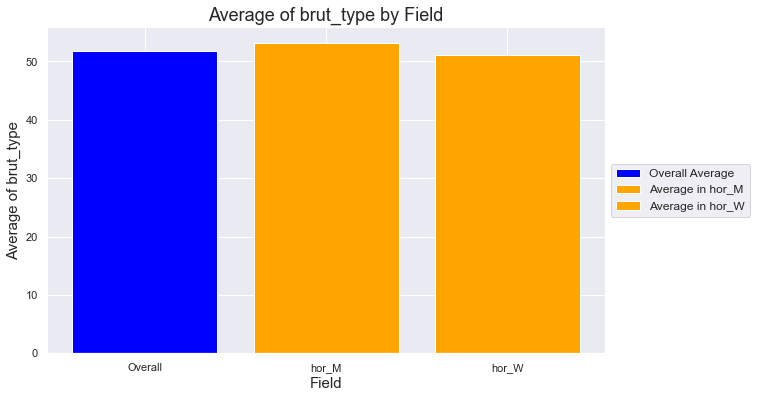

In [68]:
overall_avg_nega_emo_type = df_hor['nega_emo_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_nega_emo_type_by_field = df_hor.groupby('field')['nega_emo_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_nega_emo_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

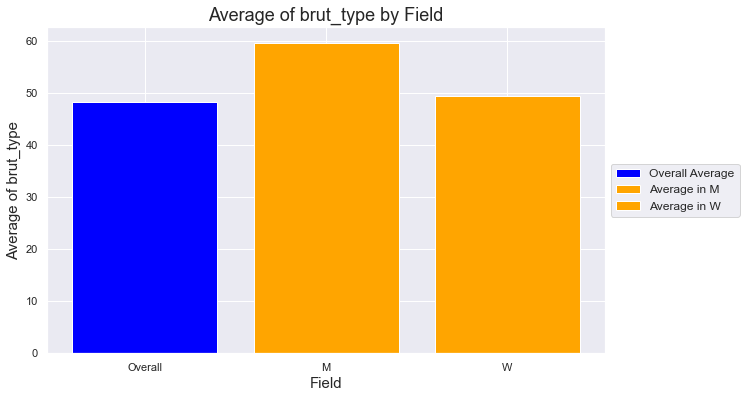

In [75]:
overall_avg_nega_emo_type = df_full['nega_emo_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_nega_emo_type_by_field = df_full.groupby('field')['nega_emo_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_nega_emo_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

In [81]:
#signifikanz bei abenteuer
from scipy import stats

male_data = df_aben[df_aben['field'] == 'aben_M']['Percentage']
female_data = df_aben[df_aben['field'] == 'aben_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'df: {df}')
print(f't_critical: {t_critical}')
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse - P-Wert
print("Ergebnis - p-Wert:")
if p_value < alpha:
    print("Bei Abenteuer: Der Unterschied im Anteil der negative Emotion zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei Abenteuer: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if abs(t_statistic) > t_critical:
    print("Bei Abenteuer: Reject H0")
else:
    print("Bei Abenteuer: don‘t reject H0")


49
114
df: 161
t_critical: 1.974808091744976
T-Statistik: -0.32137924631488346
p-Wert: 0.7483398430724335
Ergebnis - p-Wert:
Bei Abenteuer: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.
Ergebnis - T-Statistik:
Bei Abenteuer: don‘t reject H0


In [82]:
#signifikanz bei krimi

from scipy import stats

male_data = df_krimi[df_krimi['field'] == 'krimi_M']['Percentage']
female_data = df_krimi[df_krimi['field'] == 'krimi_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')
print(f'df: {df}')
print(f't_critical: {t_critical}')

# Interpretation der Ergebnisse：P-wert
if p_value < alpha:
    print("Bei Krimi: Der Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei Krimi: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if abs(t_statistic) > t_critical:
    print("Bei Krimi: Reject H0")
else:
    print("Bei Krimi: don‘t reject H0")

32
90
T-Statistik: -2.4835897203132564
p-Wert: 0.01438707747934251
df: 120
t_critical: 1.9799304050527766
Bei Krimi: Der Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren ist statistisch signifikant.
Ergebnis - T-Statistik:
Bei Krimi: Reject H0


In [83]:
#signifikanz bei horror
from scipy import stats

male_data = df_hor[df_hor['field'] == 'hor_M']['Percentage']
female_data = df_hor[df_hor['field'] == 'hor_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'df: {df}')
print(f't_critical: {t_critical}')
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse：P-wert
if p_value < alpha:
    print("Bei horror: Der Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei horror: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if abs(t_statistic) > t_critical:
    print("Bei horror: Reject H0")
else:
    print("Bei horror: don‘t reject H0")

41
72
df: 111
t_critical: 1.9815667570310707
T-Statistik: 0.11474169701667163
p-Wert: 0.9088571634036282
Bei horror: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.
Ergebnis - T-Statistik:
Bei horror: don‘t reject H0


In [84]:
from scipy import stats

male_data = df_full[df_full['field'] == 'M']['Percentage']
female_data = df_full[df_full['field'] == 'W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'df: {df}')
print(f't_critical: {t_critical}')
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse：P-wert
if p_value < alpha:
    print("Bei full: Der Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei full: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if abs(t_statistic) > t_critical:
    print("Bei full: Reject H0")
else:
    print("Bei full: don‘t reject H0")

81
204
df: 283
t_critical: 1.9683819234318902
T-Statistik: -1.7006549336534096
p-Wert: 0.09010632614997031
Bei full: Es gibt keinen statistisch signifikanten Unterschied im Anteil der der negative Emotion zwischen männlichen und weiblichen Autoren.
Ergebnis - T-Statistik:
Bei full: don‘t reject H0
